In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('novel_story_sep.csv', lineterminator='\n')

In [3]:
df.columns

Index(['itemId', 'title', 'story', 'review', 'piece'], dtype='object')

In [4]:
import gensim
gensim.__version__

'3.8.1'

In [5]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.models.wrappers import LdaMallet
import pyLDAvis
import pyLDAvis.gensim

In [6]:
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
# pyLDAvis.display(vis)
# pyLDAvis.enable_notebook()

In [7]:
df.drop_duplicates('story', inplace=True)

In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## LDA 함수 만들어놓기

In [9]:
def lda_coh(stories, no_below=5, num_topics=4, data_word=None, data_words=None):
    
    # 이야기 전체 형태소 분리
    if data_word == None:
        data_words = []
        for story in stories:
            data = list(str(story).split())
            data_words.append(data)
        
    
    if data_word == 'stop':
        data_words = []
        for story in stories:
            data = list(str(story).split())
            data_words.append(data)
            
        return data_words
    
    # id2word, corpus 추출
    id2word = corpora.Dictionary(data_words)
    id2word.filter_extremes(no_below = no_below) # no_below 회 이하로 등장한 단어는 삭제
    texts = data_words
    corpus = [id2word.doc2bow(text) for text in texts]
    
    mallet_path = '../mallet-2.0.8/bin/mallet' 
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, random_seed=12, id2word=id2word)

    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    
    return texts, corpus, ldamallet, coherence_ldamallet

In [97]:
def lda_coh_id2(stories, no_below=5, num_topics=4, data_word=None, data_words=None):
    
    # 이야기 전체 형태소 분리
    if data_word == None:
        data_words = []
        for story in stories:
            data = list(str(story).split())
            data_words.append(data)
        
    
    if data_word == 'stop':
        data_words = []
        for story in stories:
            data = list(str(story).split())
            data_words.append(data)
            
        return data_words
    
    # id2word, corpus 추출
    id2word = corpora.Dictionary(data_words)
    id2word.filter_extremes(no_below = no_below) # no_below 회 이하로 등장한 단어는 삭제
    texts = data_words
    corpus = [id2word.doc2bow(text) for text in texts]
    
    mallet_path = '../mallet-2.0.8/bin/mallet' 
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, random_seed=12, id2word=id2word)

    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    
    return texts, corpus, ldamallet, coherence_ldamallet, id2word

In [10]:
def format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df):
    # Init output

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    #ldamallet[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in enumerate(ldamallet[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamallet.show_topic(topic_num, topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print(type(sent_topics_df))

    # Add original text to the end of the output
    contents = pd.Series(data_words)
    # sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([Data['title'], Data['story'], sent_topics_df], axis=1)

    return sent_topics_df

In [11]:
def compute_coherence_values(stories, limit=10, start=4, step=2):

    from tqdm import tqdm
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        data_words = lda_coh(stories, data_word='stop')
        texts, corpus, ldamallet, coherence_ldamallet = lda_coh(stories, no_below=5, num_topics=num_topics, data_words=data_words)
        model_list.append(ldamallet)
        coherence_values.append(coherence_ldamallet)
        
    return model_list, coherence_values

### 스토리 나눠서 분석해보기

1. 책소개 (story) 

In [12]:
stories = df['story']
# df['story'] + df['review'] + df['piece']

In [13]:
limit=20; start=4; step=2;

model_list, coherence_values = compute_coherence_values(stories, limit=limit, start=start, step=step)

100%|██████████| 8/8 [04:32<00:00, 34.06s/it]


In [14]:
x = range(start, limit, step)

find_model = {}
for m,c in zip(x, coherence_values):
    find_model[m] = c
print(find_model)

{4: 0.2901921210423205, 6: 0.3002358121415844, 8: 0.2954453584367909, 10: 0.3060864642646407, 12: 0.32318150117756983, 14: 0.3107827359802199, 16: 0.29876801427084987, 18: 0.30196198534756163}


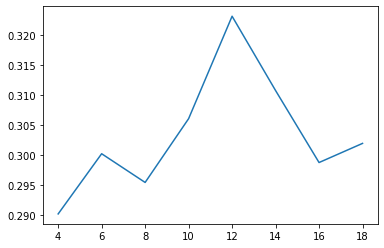

In [15]:
x = find_model.keys()
y = find_model.values()

plt.plot(x, y)
plt.show()

In [16]:
max_model = max(find_model,key=find_model.get)
texts, corpus, ldamallet, coherence_ldamallet = lda_coh(stories, num_topics=max_model)
data_words = lda_coh(stories, num_topics=max_model, data_word='stop')
df_topic_sents_keywords = format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df)

<class 'pandas.core.frame.DataFrame'>


In [17]:
max(find_model.values())

0.32318150117756983

In [18]:
# Format
df_topic_story = df_topic_sents_keywords

# 각 문서에 대한 토픽 내림차순
df_topic_sort=df_topic_story.sort_values(by=['Dominant_Topic'])

In [19]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [20]:
sent_topics_sorteddf_mallet[['Perc_Contribution', 'Dominant_Topic', 'Topic_Keywords']]

,Perc_Contribution,Dominant_Topic,Topic_Keywords
565,0.5473,0.0,"시간, 친구, 아이, 청소년, 엄마, 꿈, 생각, 소년, 날, 감정"
172,0.4796,1.0,"사람, 삶, 마음, 말, 사랑, 세상, 소녀, 자신, 스스로, 자리"
274,0.6295,2.0,"세계, 젊은, 새로운, 동시, 판타지, 이상, 여름, 주목, 영화, 판매"
250,0.5240,3.0,"사랑, 인간, 대표, 운명, 화, 세기, 과정, 묘사, 화제, 지닌"
171,0.3576,4.0,"그녀, 남자, 자신, 일, 여자, 서로, 시작, 결혼, 날, 몸"
0,0.5606,5.0,"여성, 가족, 아버지, 삶, 향, 살, 아들, 딸, 발견, 시대"
48,0.4033,6.0,"집, 세계, 삶, 편의, 사회, 의미, 현실, 시대, 발표, 다양한"
444,0.6387,7.0,"자신, 존재, 새로운, 주인공, 누구, 대상, 모습, 서사, 목소리, 손"
236,0.6251,8.0,"그린, 역사, 조선, 달, 배경, 로맨스, 왕, 여인, 전개, 차"
639,0.4070,9.0,"사건, 미스터리, 스릴러, 살인, 심리, 경찰, 매력, 서점, 반전, 충격"


In [21]:
df_topic_story.value_counts('Dominant_Topic').sort_index()

Dominant_Topic
0.0     55
1.0     47
2.0     54
3.0     63
4.0     60
5.0     57
6.0     74
7.0     43
8.0     40
9.0     77
10.0    39
11.0    36
dtype: int64

2. 서평 (review) 

In [22]:
stories = df['review']
# df['story'] + df['review'] + df['piece']

In [23]:
limit=20; start=4; step=2;

model_list, coherence_values = compute_coherence_values(stories, limit=limit, start=start, step=step)

100%|██████████| 8/8 [05:32<00:00, 41.55s/it]


In [24]:
x = range(start, limit, step)

find_model = {}
for m,c in zip(x, coherence_values):
    find_model[m] = c
print(find_model)

{4: 0.3220955066837471, 6: 0.3653328674529936, 8: 0.39012893644947433, 10: 0.4090067934353466, 12: 0.389039125408187, 14: 0.39991153690384246, 16: 0.4057744946471859, 18: 0.4029007521406507}


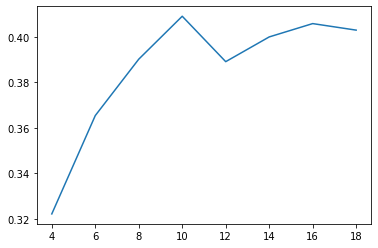

In [25]:
x = find_model.keys()
y = find_model.values()

plt.plot(x, y)
plt.show()

In [26]:
max_model = max(find_model,key=find_model.get)
texts, corpus, ldamallet, coherence_ldamallet = lda_coh(stories, num_topics=max_model)
data_words = lda_coh(stories, num_topics=max_model, data_word='stop')
df_topic_sents_keywords = format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df)

<class 'pandas.core.frame.DataFrame'>


In [27]:
max(find_model.values())

0.4090067934353466

In [28]:
# Format
df_topic_story = df_topic_sents_keywords

# 각 문서에 대한 토픽 내림차순
df_topic_sort=df_topic_story.sort_values(by=['Dominant_Topic'])

In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [30]:
sent_topics_sorteddf_mallet[['Perc_Contribution', 'Dominant_Topic', 'Topic_Keywords']]

,Perc_Contribution,Dominant_Topic,Topic_Keywords
418,0.7919,0.0,"그녀, 눈, 몸, 남자, 손, 얼굴, 여자, 소리, 입, 처음"
97,0.8476,1.0,"현재, 전쟁, 사이, 과거, 역사, 임, 인간, 시, 명, 현실"
489,0.6528,2.0,"사건, 미스터리, 남자, 반전, 진실, 살인, 스릴러, 상, 범인, 형사"
77,0.5600,3.0,"집, 서로, 시간, 순간, 감정, 쪽, 존재, 기억, 관계, 이해"
485,0.6573,4.0,"인간, 시대, 대표, 역사, 세기, 의미, 사회, 중국, 주의, 의식"
108,0.6381,5.0,"인간, 주인공, 존재, 사회, 현실, 미래, 새로운, 밤, 등장, 우주"
111,0.8991,6.0,"언어, 글, 사회, 결정, 새로운, 경험, 시대, 시선, 다양한, 판"
293,0.5633,7.0,"아이, 친구, 시간, 엄마, 청소년, 꿈, 소년, 학교, 가족, 고민"
302,0.9384,8.0,"조선, 로맨스, 판타지, 세월, 여인, 감동, 향, 웹소설, 제작, 돌"
172,0.6314,9.0,"죽음, 아버지, 살, 가족, 아들, 인생, 날, 사실, 운명, 도시"


In [31]:
df_topic_story.value_counts('Dominant_Topic').sort_index()

Dominant_Topic
0.0     48
1.0     29
2.0     98
3.0    101
4.0     86
5.0     71
6.0     14
7.0     91
8.0     43
9.0     64
dtype: int64

3. 책내용 일부 (piece) 

In [32]:
stories = df['piece']
# df['story'] + df['review'] + df['piece']

In [33]:
limit=20; start=4; step=2;

model_list, coherence_values = compute_coherence_values(stories, limit=limit, start=start, step=step)

100%|██████████| 8/8 [05:06<00:00, 38.27s/it]


In [34]:
x = range(start, limit, step)

find_model = {}
for m,c in zip(x, coherence_values):
    find_model[m] = c
print(find_model)

{4: 0.3385571328156868, 6: 0.31194339096639573, 8: 0.3295811114329128, 10: 0.32734448925532644, 12: 0.3235091357706808, 14: 0.3246693577455429, 16: 0.31413986996719123, 18: 0.32799673719900535}


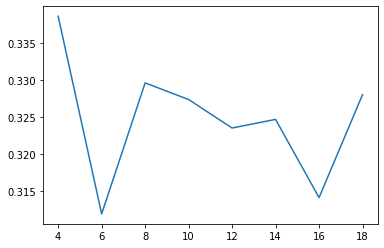

In [35]:
x = find_model.keys()
y = find_model.values()

plt.plot(x, y)
plt.show()

In [36]:
max_model = max(find_model,key=find_model.get)
texts, corpus, ldamallet, coherence_ldamallet = lda_coh(stories, num_topics=max_model)
data_words = lda_coh(stories, num_topics=max_model, data_word='stop')
df_topic_sents_keywords = format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df)

<class 'pandas.core.frame.DataFrame'>


In [37]:
max(find_model.values())

0.3385571328156868

In [38]:
# Format
df_topic_story = df_topic_sents_keywords

# 각 문서에 대한 토픽 내림차순
df_topic_sort=df_topic_story.sort_values(by=['Dominant_Topic'])

In [39]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [40]:
sent_topics_sorteddf_mallet[['Perc_Contribution', 'Dominant_Topic', 'Topic_Keywords']]

,Perc_Contribution,Dominant_Topic,Topic_Keywords
327,0.7879,0.0,"그녀, 눈, 얼굴, 손, 소리, 몸, 머리, 목소리, 입, 고개"
341,0.5739,1.0,"당신, 인간, 사실, 여자, 존재, 삶, 세계, 죽음, 남자, 순간"
143,0.5373,2.0,"마음, 엄마, 사랑, 세상, 살, 나를, 날, 집, 아이, 건"
4,0.8376,3.0,"시간, 요, 여기, 몇, 시작, 꿈, 줄, 끝, 돈, 정말"


In [41]:
df_topic_story.value_counts('Dominant_Topic').sort_index()

Dominant_Topic
0.0    171
1.0    192
2.0    200
3.0     82
dtype: int64

4. 책소개 (story) + 서평 (review)

In [42]:
stories = df['story'] + df['review']
# df['story'] + df['review'] + df['piece']

In [43]:
limit=20; start=4; step=2;

model_list, coherence_values = compute_coherence_values(stories, limit=limit, start=start, step=step)

100%|██████████| 8/8 [06:00<00:00, 45.01s/it]


In [44]:
x = range(start, limit, step)

find_model = {}
for m,c in zip(x, coherence_values):
    find_model[m] = c
print(find_model)

{4: 0.3373586186626695, 6: 0.39059541839388295, 8: 0.38586105913263724, 10: 0.4201821884276328, 12: 0.3973658003938066, 14: 0.4156957421963203, 16: 0.400227514787666, 18: 0.3863908878994455}


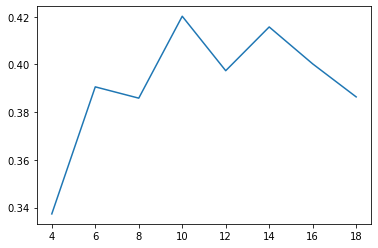

In [45]:
x = find_model.keys()
y = find_model.values()

plt.plot(x, y)
plt.show()

In [46]:
max_model = max(find_model,key=find_model.get)
texts, corpus, ldamallet, coherence_ldamallet = lda_coh(stories, num_topics=max_model)
data_words = lda_coh(stories, num_topics=max_model, data_word='stop')
df_topic_sents_keywords = format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df)

<class 'pandas.core.frame.DataFrame'>


In [47]:
max(find_model.values())

0.4201821884276328

In [48]:
# Format
df_topic_story = df_topic_sents_keywords

# 각 문서에 대한 토픽 내림차순
df_topic_sort=df_topic_story.sort_values(by=['Dominant_Topic'])

In [49]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [50]:
sent_topics_sorteddf_mallet[['Perc_Contribution', 'Dominant_Topic', 'Topic_Keywords']]

,Perc_Contribution,Dominant_Topic,Topic_Keywords
620,0.8156,0.0,"현실, 영혼, 여행, 시, 밤, 사이, 서사, 환상, 시대, 재난"
172,0.7727,1.0,"죽음, 아버지, 존재, 아들, 쪽, 마을, 가족, 소녀, 도시, 사고"
58,0.5469,2.0,"집, 기억, 젊은, 서로, 사실, 순간, 사이, 존재, 과거, 방식"
418,0.6937,3.0,"그녀, 남자, 여자, 눈, 몸, 당신, 기억, 얼굴, 손, 입"
302,0.9503,4.0,"역사, 조선, 왕, 여인, 꽃, 로맨스, 향, 운명, 그녀, 감동"
489,0.7275,5.0,"사건, 미스터리, 진실, 살인, 스릴러, 반전, 경찰, 범인, 형사, 추리"
304,0.7123,6.0,"재미, 이상, 인생, 판타지, 매력, 만큼, 비밀, 수학, 소재, 세월"
111,0.8956,7.0,"시대, 전쟁, 대표, 사회, 역사, 언어, 결정, 판, 의미, 글"
233,0.7339,8.0,"여성, 사회, 미래, 욕망, 결혼, 사실, 현실, 지구, 인류, 중국"
477,0.6067,9.0,"아이, 친구, 엄마, 청소년, 꿈, 가족, 학교, 상처, 인생, 고민"


In [51]:
df_topic_story.value_counts('Dominant_Topic').sort_index()

Dominant_Topic
0.0    30
1.0    54
2.0    81
3.0    51
4.0    51
5.0    95
6.0    58
7.0    65
8.0    61
9.0    99
dtype: int64

5. 서평 (review) + 책내용 일부 (piece)

In [52]:
stories = df['review']
# df['story'] + df['review'] + df['piece']

In [53]:
limit=20; start=4; step=2;

model_list, coherence_values = compute_coherence_values(stories, limit=limit, start=start, step=step)

100%|██████████| 8/8 [05:36<00:00, 42.10s/it]


In [54]:
x = range(start, limit, step)

find_model = {}
for m,c in zip(x, coherence_values):
    find_model[m] = c
print(find_model)

{4: 0.3220955066837471, 6: 0.3653328674529936, 8: 0.39012893644947433, 10: 0.4090067934353466, 12: 0.389039125408187, 14: 0.39991153690384246, 16: 0.4057744946471859, 18: 0.4029007521406507}


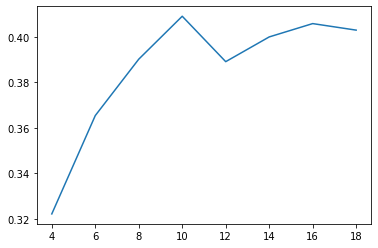

In [55]:
x = find_model.keys()
y = find_model.values()

plt.plot(x, y)
plt.show()

In [56]:
max(find_model.values())

0.4090067934353466

In [57]:
max_model = max(find_model,key=find_model.get)
texts, corpus, ldamallet, coherence_ldamallet = lda_coh(stories, num_topics=max_model)
data_words = lda_coh(stories, num_topics=max_model, data_word='stop')
df_topic_sents_keywords = format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df)

<class 'pandas.core.frame.DataFrame'>


In [58]:
# Format
df_topic_story = df_topic_sents_keywords

# 각 문서에 대한 토픽 내림차순
df_topic_sort=df_topic_story.sort_values(by=['Dominant_Topic'])

In [59]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [60]:
sent_topics_sorteddf_mallet[['Perc_Contribution', 'Dominant_Topic', 'Topic_Keywords']]

,Perc_Contribution,Dominant_Topic,Topic_Keywords
418,0.7919,0.0,"그녀, 눈, 몸, 남자, 손, 얼굴, 여자, 소리, 입, 처음"
97,0.8476,1.0,"현재, 전쟁, 사이, 과거, 역사, 임, 인간, 시, 명, 현실"
489,0.6528,2.0,"사건, 미스터리, 남자, 반전, 진실, 살인, 스릴러, 상, 범인, 형사"
77,0.5600,3.0,"집, 서로, 시간, 순간, 감정, 쪽, 존재, 기억, 관계, 이해"
485,0.6573,4.0,"인간, 시대, 대표, 역사, 세기, 의미, 사회, 중국, 주의, 의식"
108,0.6381,5.0,"인간, 주인공, 존재, 사회, 현실, 미래, 새로운, 밤, 등장, 우주"
111,0.8991,6.0,"언어, 글, 사회, 결정, 새로운, 경험, 시대, 시선, 다양한, 판"
293,0.5633,7.0,"아이, 친구, 시간, 엄마, 청소년, 꿈, 소년, 학교, 가족, 고민"
302,0.9384,8.0,"조선, 로맨스, 판타지, 세월, 여인, 감동, 향, 웹소설, 제작, 돌"
172,0.6314,9.0,"죽음, 아버지, 살, 가족, 아들, 인생, 날, 사실, 운명, 도시"


In [61]:
df_topic_story.value_counts('Dominant_Topic').sort_index()

Dominant_Topic
0.0     48
1.0     29
2.0     98
3.0    101
4.0     86
5.0     71
6.0     14
7.0     91
8.0     43
9.0     64
dtype: int64

6. 책소개 (story) + 책내용 일부 (piece) 

In [62]:
stories = df['piece']
# df['story'] + df['review'] + df['piece']

In [63]:
limit=20; start=4; step=2;

model_list, coherence_values = compute_coherence_values(stories, limit=limit, start=start, step=step)

100%|██████████| 8/8 [05:01<00:00, 37.70s/it]


In [64]:
x = range(start, limit, step)

find_model = {}
for m,c in zip(x, coherence_values):
    find_model[m] = c
print(find_model)

{4: 0.3385571328156868, 6: 0.31194339096639573, 8: 0.3295811114329128, 10: 0.32734448925532644, 12: 0.3235091357706808, 14: 0.3246693577455429, 16: 0.31413986996719123, 18: 0.32799673719900535}


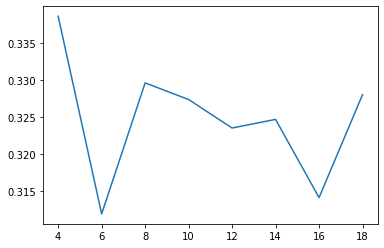

In [65]:
x = find_model.keys()
y = find_model.values()

plt.plot(x, y)
plt.show()

In [66]:
max_model = max(find_model,key=find_model.get)
texts, corpus, ldamallet, coherence_ldamallet = lda_coh(stories, num_topics=max_model)
data_words = lda_coh(stories, num_topics=max_model, data_word='stop')
df_topic_sents_keywords = format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df)

<class 'pandas.core.frame.DataFrame'>


In [67]:
max(find_model.values())

0.3385571328156868

In [68]:
# Format
df_topic_story = df_topic_sents_keywords

# 각 문서에 대한 토픽 내림차순
df_topic_sort=df_topic_story.sort_values(by=['Dominant_Topic'])

In [69]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [70]:
sent_topics_sorteddf_mallet[['Perc_Contribution', 'Dominant_Topic', 'Topic_Keywords']]

,Perc_Contribution,Dominant_Topic,Topic_Keywords
327,0.7879,0.0,"그녀, 눈, 얼굴, 손, 소리, 몸, 머리, 목소리, 입, 고개"
341,0.5739,1.0,"당신, 인간, 사실, 여자, 존재, 삶, 세계, 죽음, 남자, 순간"
143,0.5373,2.0,"마음, 엄마, 사랑, 세상, 살, 나를, 날, 집, 아이, 건"
4,0.8376,3.0,"시간, 요, 여기, 몇, 시작, 꿈, 줄, 끝, 돈, 정말"


In [71]:
df_topic_story.value_counts('Dominant_Topic').sort_index()

Dominant_Topic
0.0    171
1.0    192
2.0    200
3.0     82
dtype: int64

7. 책소개 (story) + 책리뷰 (review) +  책내용 일부 (piece) 

In [72]:
stories = df['piece'] + df['story'] + df['review'] 
# df['story'] + df['review'] + df['piece']

In [73]:
limit=20; start=4; step=2;

model_list, coherence_values = compute_coherence_values(stories, limit=limit, start=start, step=step)

100%|██████████| 8/8 [06:24<00:00, 48.09s/it]


In [74]:
x = range(start, limit, step)

find_model = {}
for m,c in zip(x, coherence_values):
    find_model[m] = c
print(find_model)

{4: 0.34514383396608905, 6: 0.4005510082519343, 8: 0.3739084626497442, 10: 0.40895756440663134, 12: 0.4016815265768625, 14: 0.4050147646714552, 16: 0.39889784599060224, 18: 0.3997322369164255}


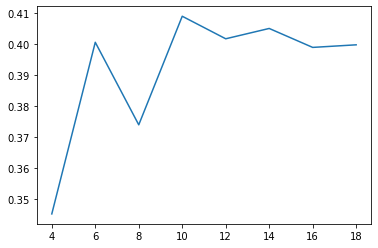

In [75]:
x = find_model.keys()
y = find_model.values()

plt.plot(x, y)
plt.show()

In [85]:
max_model = max(find_model,key=find_model.get)
texts, corpus, ldamallet, coherence_ldamallet = lda_coh(stories, num_topics=max_model)
data_words = lda_coh(stories, num_topics=max_model, data_word='stop')
df_topic_sents_keywords = format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df)

<class 'pandas.core.frame.DataFrame'>


In [86]:
max(find_model.values())

0.40895756440663134

In [87]:
# Format
df_topic_story = df_topic_sents_keywords

# 각 문서에 대한 토픽 내림차순
df_topic_sort=df_topic_story.sort_values(by=['Dominant_Topic'])

In [88]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [89]:
sent_topics_sorteddf_mallet[['Perc_Contribution', 'Dominant_Topic', 'Topic_Keywords']]

,Perc_Contribution,Dominant_Topic,Topic_Keywords
620,0.8107,0.0,"꿈, 현실, 우주, 미래, 인류, 지구, 시, 과학, 현재, 과거"
404,0.5612,1.0,"사건, 미스터리, 남자, 살인, 진실, 스릴러, 반전, 경찰, 범인, 형사"
111,0.8367,2.0,"사회, 언어, 의미, 글, 결정, 시절, 경험, 함, 큰, 어머니"
74,0.5301,3.0,"여자, 남자, 그녀, 여성, 서로, 당신, 결혼, 자리, 관계, 이유"
565,0.5743,4.0,"아이, 엄마, 친구, 청소년, 아빠, 학교, 할머니, 가족, 꿈, 어른"
418,0.7132,5.0,"그녀, 몸, 마을, 소리, 나무, 얼굴, 땅, 눈물, 새, 머리"
1,0.6654,6.0,"아버지, 인생, 사회, 죽음, 전쟁, 길, 자기, 선, 아들, 운명"
301,0.9390,7.0,"역사, 대표, 시대, 여인, 중국, 조선, 소개, 감동, 현대, 진"
3,0.6912,8.0,"기억, 죽음, 감정, 면, 누군가, 밤, 서로, 타인, 끝, 고통"
326,0.9330,9.0,"얼굴, 그녀, 고개, 몸, 입, 이상, 피, 로맨스, 목소리, 줄"


In [90]:
df_topic_story.value_counts('Dominant_Topic').sort_index()

Dominant_Topic
0.0    48
1.0    83
2.0    36
3.0    64
4.0    92
5.0    51
6.0    87
7.0    44
8.0    84
9.0    56
dtype: int64

---

## 선택된 모델(책소개, 서평 / 10개 분류)로 토픽분류 시각화

In [109]:
stories = df['story'] + df['review']
# df['story'] + df['review'] + df['piece']

In [110]:
texts, corpus, ldamallet, coherence_ldamallet, id2word = lda_coh_id2(stories, num_topics=10)
data_words = lda_coh(stories, num_topics=max_model, data_word='stop')
df_topic_sents_keywords = format_topics_sentences(texts, corpus, data_words, ldamallet, Data=df)

<class 'pandas.core.frame.DataFrame'>


In [111]:
from gensim.models import LdaModel

def mallet_to_lda(optimal_model):
   model_gensim = LdaModel(
       id2word=optimal_model.id2word, num_topics=optimal_model.num_topics,
       alpha=optimal_model.alpha, eta=0, iterations=1000,
       gamma_threshold=0.001,
       dtype=np.float32
   )
   model_gensim.sync_state()
   model_gensim.state.sstats = optimal_model.wordtopics

   return model_gensim

optimal_model = ldamallet
model = mallet_to_lda(optimal_model)

import pyLDAvis
import pyLDAvis.gensim as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, corpus, id2word)
vis

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.007423  0.301699       1        1  10.402766
1     -0.144505  0.122912       2        1  10.337076
2     -0.067215  0.024972       3        1  10.278657
7      0.118313 -0.193588       4        1  10.124871
0     -0.117514 -0.163863       5        1  10.033304
5      0.088954  0.049169       6        1   9.996548
9     -0.081631 -0.044924       7        1   9.968527
4      0.039212  0.092563       8        1   9.838884
8     -0.169808 -0.152909       9        1   9.599445
6      0.341616 -0.036031      10        1   9.419923, topic_info=    Term         Freq        Total Category  logprob  loglift
176   사건  1010.000000  1010.000000  Default  30.0000  30.0000
228   아이   901.000000   901.000000  Default  29.0000  29.0000
55    그녀  1047.000000  1047.000000  Default  28.0000  28.0000
241   여성   532.000000   532.000000  Default  27.0000  27.0000
697    집   848.000000   848.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
716    큰   126.196279   445.988242  Topic10  -5.4269   1.0999
315   처음   116.934167   404.206637  Topic10  -5.5031   1.1220
571    손   115.776403   507.774142  Topic10  -5.5131   0.8840
228   아이   122.722987   901.339507  Topic10  -5.4548   0.3684
100   대표   109.987583   404.394717  Topic10  -5.5644   1.0603

[897 rows x 6 columns], token_table=      Topic      Freq Term
term                      
7071      6  1.004934   가가
1870      1  1.011492   가기
0         7  0.979301  가난한
1090      1  0.030403  가능한
1090      3  0.942499  가능한
...     ...       ...  ...
370       4  0.128064    힘
370       7  0.253617    힘
370       9  0.228507    힘
373       7  1.057645   힘들
760       5  1.007314  힘들게

[1405 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 8, 1, 6, 10, 5, 9, 7])

In [101]:
# Format
df_topic_story = df_topic_sents_keywords

# 각 문서에 대한 토픽 내림차순
df_topic_sort=df_topic_story.sort_values(by=['Dominant_Topic'])

In [102]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)


In [103]:
sent_topics_sorteddf_mallet[['Perc_Contribution', 'Dominant_Topic', 'Topic_Keywords']]

,Perc_Contribution,Dominant_Topic,Topic_Keywords
620,0.8156,0.0,"현실, 영혼, 여행, 시, 밤, 사이, 서사, 환상, 시대, 재난"
172,0.7727,1.0,"죽음, 아버지, 존재, 아들, 쪽, 마을, 가족, 소녀, 도시, 사고"
58,0.5469,2.0,"집, 기억, 젊은, 서로, 사실, 순간, 사이, 존재, 과거, 방식"
418,0.6937,3.0,"그녀, 남자, 여자, 눈, 몸, 당신, 기억, 얼굴, 손, 입"
302,0.9503,4.0,"역사, 조선, 왕, 여인, 꽃, 로맨스, 향, 운명, 그녀, 감동"
489,0.7275,5.0,"사건, 미스터리, 진실, 살인, 스릴러, 반전, 경찰, 범인, 형사, 추리"
304,0.7123,6.0,"재미, 이상, 인생, 판타지, 매력, 만큼, 비밀, 수학, 소재, 세월"
111,0.8956,7.0,"시대, 전쟁, 대표, 사회, 역사, 언어, 결정, 판, 의미, 글"
233,0.7339,8.0,"여성, 사회, 미래, 욕망, 결혼, 사실, 현실, 지구, 인류, 중국"
477,0.6067,9.0,"아이, 친구, 엄마, 청소년, 꿈, 가족, 학교, 상처, 인생, 고민"


In [104]:
df_topic_story.value_counts('Dominant_Topic').sort_index()

Dominant_Topic
0.0    30
1.0    54
2.0    81
3.0    51
4.0    51
5.0    95
6.0    58
7.0    65
8.0    61
9.0    99
dtype: int64

In [107]:
df_topic_story.to_csv('소설_책내용_서평기반_LDA_완료.csv')

In [108]:
df_topic_story

,title,story,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,파친코 1,자이니치 분노 슬픔 탄생 대작 세인 이민 진의 파친코 국 면서 끝내 이방인 일 자이...,4.0,0.3460,"역사, 조선, 왕, 여인, 꽃, 로맨스, 향, 운명, 그녀, 감동"
1,파친코 2,자이니치 분노 슬픔 탄생 대작 세인 이민 진의 파친코 국 면서 끝내 이방인 일 자이...,4.0,0.3489,"역사, 조선, 왕, 여인, 꽃, 로맨스, 향, 운명, 그녀, 감동"
2,불편한 편의점(40만부 기념 벚꽃 에디션),인터넷 한정 특별판 매장 구매 드림 구매 시 표지 에디 션 제공 됩니다 원 플러스 ...,9.0,0.2821,"아이, 친구, 엄마, 청소년, 꿈, 가족, 학교, 상처, 인생, 고민"
3,아몬드,괴물 괴물 만났다 영화 강렬한 사건 매혹 문체 시선 사로잡는 어덜트 아몬드 타인 감...,0.0,0.3956,"현실, 영혼, 여행, 시, 밤, 사이, 서사, 환상, 시대, 재난"
4,달러구트 꿈 백화점(100만부 기념 합본호: Gift Edition),책장 덮은 오늘 밤 당신 꿈 이어집니다 달러 구트 꿈 백화점 돌파 특별 합본 판타지...,9.0,0.2747,"아이, 친구, 엄마, 청소년, 꿈, 가족, 학교, 상처, 인생, 고민"
...,...,...,...,...,...
640,후원에 핀 제비꽃 4,잔혹 매혹 공존 운명 로맨스 판타지 후원 핀 제비꽃 성녀 자신 세상 버린 기사 살 ...,4.0,0.3029,"역사, 조선, 왕, 여인, 꽃, 로맨스, 향, 운명, 그녀, 감동"
641,사기꾼의 심장은 천천히 뛴다,출장 신기한 사실 비밀 평범한 직장인 일상 인간관계 세계관 인생 송두리째 바뀐다 상...,6.0,0.2889,"재미, 이상, 인생, 판타지, 매력, 만큼, 비밀, 수학, 소재, 세월"
642,머드(MUD),사랑 죽 바닥 가라앉았던 마음 순식간 목 끝 튀어 오르고 눈 멀 정도 눈부신 빛 켜...,8.0,0.2320,"여성, 사회, 미래, 욕망, 결혼, 사실, 현실, 지구, 인류, 중국"
643,복자는 울지 않았다,정낙추 집 복자 울 개발 이윤 논리 훼손 시대 자화상 민중 입담 밀도 표 제작 주인...,9.0,0.1699,"아이, 친구, 엄마, 청소년, 꿈, 가족, 학교, 상처, 인생, 고민"
